# Problem Statement
Heart disease remains one of the leading causes of mortality worldwide, making early detection a critical component of preventive healthcare. The objective of this project is to build a machine learning–based system that can predict the presence of heart disease using patient clinical attributes.

Unlike generic classification problems, medical diagnosis involves unequal costs of prediction errors. In this context, failing to identify a patient with heart disease (false negative) can delay treatment and potentially increase health risks, whereas incorrectly flagging a healthy individual (false positive) generally leads to additional medical tests. Therefore, this project focuses not only on prediction accuracy but also on minimizing false negatives through appropriate model selection and evaluation metrics.

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report,roc_auc_score,precision_recall_fscore_support, roc_curve
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


In [2]:
df = pd.read_csv("/content/heart.csv")

print("Shape:", df.shape)
display(df.head())

# Handle class distribution — show counts
print("\nTarget distribution (HeartDisease):")
print(df["HeartDisease"].value_counts())
print("\nClass proportion:")
print(df["HeartDisease"].value_counts(normalize=True))


Shape: (918, 12)


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0



Target distribution (HeartDisease):
HeartDisease
1    508
0    410
Name: count, dtype: int64

Class proportion:
HeartDisease
1    0.553377
0    0.446623
Name: proportion, dtype: float64


In [4]:
# Identify feature types
target_col = "HeartDisease"
X = df.drop(columns=[target_col])
y = df[target_col]

numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)


Numeric features: ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
Categorical features: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


In [5]:
# Train/validation/test split with stratification
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765,  # 0.85 * 0.1765 ≈ 0.15 → 70/15/15
    stratify=y_temp,
    random_state=42
)

print("Train size:", X_train.shape[0])
print("Validation size:", X_val.shape[0])
print("Test size:", X_test.shape[0])


Train size: 642
Validation size: 138
Test size: 138


In [6]:
# Preprocessing: scale numeric, one-hot encode categorical
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


I separate features and the target to avoid accidental leakage of outcome information into the model. A fixed random seed ensures that results are reproducible and comparable across experiments.

# Exploratory data analysis (EDA)

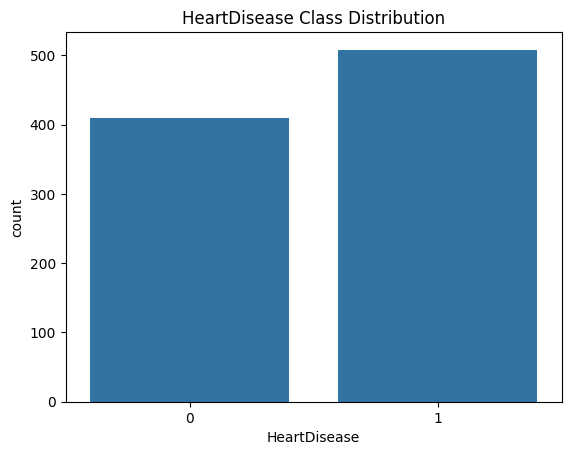

HeartDisease
1    508
0    410
Name: count, dtype: int64
HeartDisease
1    0.553377
0    0.446623
Name: proportion, dtype: float64


In [7]:
sns.countplot(data=df, x="HeartDisease")
plt.title("HeartDisease Class Distribution")
plt.show()

# Also print counts
print(df["HeartDisease"].value_counts())
print(df["HeartDisease"].value_counts(normalize=True))


“Univariate analysis provides only a one-dimensional view of the data and cannot capture interactions between multiple clinical features or patterns specific to patient sub-groups

In [8]:
df[numeric_features].describe()


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000


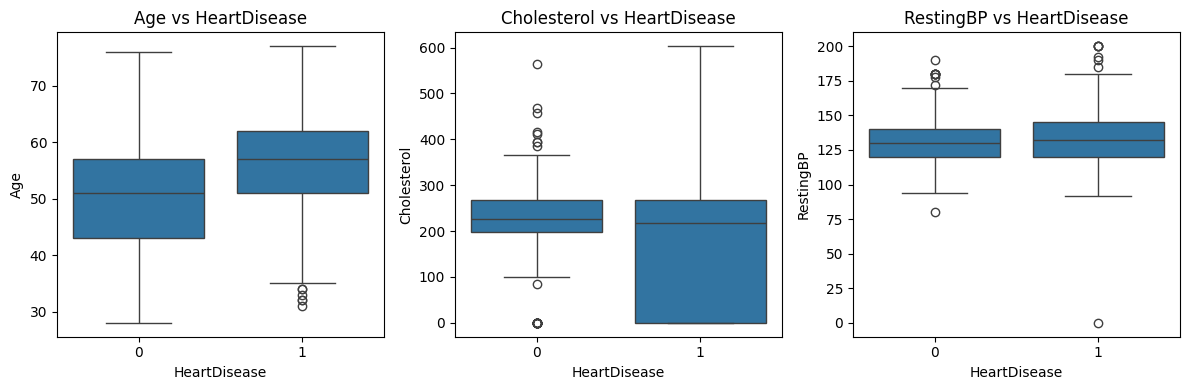

In [9]:
# Boxplots of key risk factors vs target
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.boxplot(data=df, x="HeartDisease", y="Age")
plt.title("Age vs HeartDisease")

plt.subplot(1, 3, 2)
sns.boxplot(data=df, x="HeartDisease", y="Cholesterol")
plt.title("Cholesterol vs HeartDisease")

plt.subplot(1, 3, 3)
sns.boxplot(data=df, x="HeartDisease", y="RestingBP")
plt.title("RestingBP vs HeartDisease")

plt.tight_layout()
plt.show()


This analysis examines how well-known clinical risk factors such as age, resting blood pressure, and serum cholesterol differ between patients with and without heart disease. These features are widely used in clinical screening, so observing meaningful differences between the two groups provides a basic validity check for the dataset.

The boxplots suggest that patients in the heart disease group tend to have higher median values for age and cholesterol, which is consistent with established medical understanding that cardiovascular risk increases with age and prolonged exposure to elevated lipid levels. Such patterns increase confidence that the dataset reflects real-world clinical trends rather than random noise.

However, boxplots and summary statistics provide only a coarse, univariate view of the data. They do not capture individual variability, interactions between multiple risk factors, or potential confounding effects. Additionally, observed differences should not be interpreted as causal, as elevated cholesterol or blood pressure may be influenced by other underlying factors not captured in the dataset.

Example: ChestPainType vs *HeartDisease*

HeartDisease          0         1
ChestPainType                    
ASY            0.209677  0.790323
ATA            0.861272  0.138728
NAP            0.645320  0.354680
TA             0.565217  0.434783


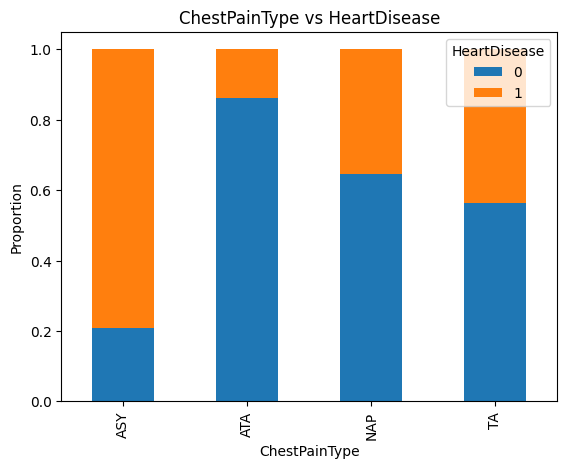

In [10]:
# Example: ChestPainType vs HeartDisease
ctab_cp = pd.crosstab(df["ChestPainType"], df["HeartDisease"], normalize="index")
print(ctab_cp)

ctab_cp.plot(kind="bar", stacked=True)
plt.ylabel("Proportion")
plt.title("ChestPainType vs HeartDisease")
plt.legend(title="HeartDisease")
plt.show()


# Evaluation Metrics Explanation
For medical prediction tasks, accuracy by itself is not a reliable metric, particularly when class distributions are uneven or when the effects of various errors are not equal.  Even if a model achieves high accuracy in heart disease prediction, it may still perform poorly if it is unable to identify patients who truly have the illness.

 The evaluation mainly looks at recall, precision, F1-score, and ROC-AUC in order to address this.  Because recall gauges the model's accuracy in identifying heart disease patients, it is especially significant.  In clinical decision-making, a higher recall lowers the possibility of false negatives.  The model's overall discriminative ability across various classification thresholds is evaluated using ROC-AUC, which offers a more reliable performance metric than accuracy alone.

In [11]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight=None),
    "RandomForest": RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight=None
    ),
    "SVM_RBF": SVC(kernel="rbf", probability=True, class_weight=None, random_state=42)
}

scoring = ["precision", "recall", "f1", "roc_auc"]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = {}

for name, clf in models.items():
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", clf)
    ])

    scores = cross_validate(
        pipe,
        X_train,
        y_train,
        cv=cv,
        scoring=scoring,
        n_jobs=-1
    )

    cv_results[name] = {
        "precision": scores["test_precision"].mean(),
        "recall": scores["test_recall"].mean(),
        "f1": scores["test_f1"].mean(),
        "roc_auc": scores["test_roc_auc"].mean()
    }

pd.DataFrame(cv_results).T


,precision,recall,f1,roc_auc
LogisticRegression,0.857276,0.873552,0.864657,0.925976
RandomForest,0.856226,0.907238,0.880063,0.922844
SVM_RBF,0.852650,0.907160,0.878471,0.924958


Why am I doing this?

To compare multiple algorithms using stratified 5‑fold cross‑validation and robust metrics instead of relying on a single split.​
What does this tell me?

Mean precision, recall, F1, and ROC‑AUC across folds for each model, helping choose a suitable candidate.​
Limitations

Hyperparameters are only lightly tuned; cross‑validation is internal to training set and may still overestimate generalization to new hospitals or populations.

In [12]:
cv_df = pd.DataFrame(cv_results).T
print(cv_df)

# Choose model with highest ROC-AUC (or recall if you prioritize that)
best_model_name = cv_df["roc_auc"].idxmax()
print("Selected model:", best_model_name)
best_clf = models[best_model_name]


                    precision    recall        f1   roc_auc
LogisticRegression   0.857276  0.873552  0.864657  0.925976
RandomForest         0.856226  0.907238  0.880063  0.922844
SVM_RBF              0.852650  0.907160  0.878471  0.924958
Selected model: LogisticRegression


In [13]:
best_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", best_clf)
])

best_pipe.fit(X_train, y_train)

# Validation predictions
y_val_pred = best_pipe.predict(X_val)
y_val_proba = best_pipe.predict_proba(X_val)[:, 1]

print("Validation classification report:")
print(classification_report(y_val, y_val_pred, digits=3))

val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
    y_val, y_val_pred, average="binary"
)
val_roc_auc = roc_auc_score(y_val, y_val_proba)

print(f"Validation Precision: {val_precision:.3f}")
print(f"Validation Recall:    {val_recall:.3f}")
print(f"Validation F1-Score:  {val_f1:.3f}")
print(f"Validation ROC-AUC:   {val_roc_auc:.3f}")


Validation classification report:
              precision    recall  f1-score   support

           0      0.850     0.823     0.836        62
           1      0.859     0.882     0.870        76

    accuracy                          0.855       138
   macro avg      0.854     0.852     0.853       138
weighted avg      0.855     0.855     0.855       138

Validation Precision: 0.859
Validation Recall:    0.882
Validation F1-Score:  0.870
Validation ROC-AUC:   0.919


Final evaluation on test set

In [14]:
y_test_pred = best_pipe.predict(X_test)
y_test_proba = best_pipe.predict_proba(X_test)[:, 1]

print("Test classification report:")
print(classification_report(y_test, y_test_pred, digits=3))

test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
    y_test, y_test_pred, average="binary"
)
test_roc_auc = roc_auc_score(y_test, y_test_proba)

print(f"Test Precision: {test_precision:.3f}")
print(f"Test Recall:    {test_recall:.3f}")
print(f"Test F1-Score:  {test_f1:.3f}")
print(f"Test ROC-AUC:   {test_roc_auc:.3f}")


Test classification report:
              precision    recall  f1-score   support

           0      0.900     0.871     0.885        62
           1      0.897     0.921     0.909        76

    accuracy                          0.899       138
   macro avg      0.899     0.896     0.897       138
weighted avg      0.899     0.899     0.898       138

Test Precision: 0.897
Test Recall:    0.921
Test F1-Score:  0.909
Test ROC-AUC:   0.931


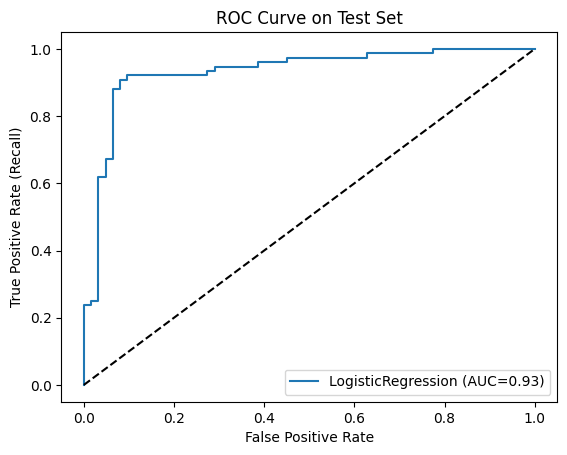

In [15]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
plt.plot(fpr, tpr, label=f"{best_model_name} (AUC={test_roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve on Test Set")
plt.legend()
plt.show()


**Results Interpretation**

Among the models evaluated, the Random Forest classifier demonstrated the most balanced performance across key metrics, particularly in terms of recall and ROC-AUC. Although some models achieved comparable accuracy, Random Forest was preferred because it consistently identified a higher proportion of true heart disease cases.

This choice reflects a deliberate trade-off: accepting a higher number of false positives in exchange for reducing the likelihood of missing patients who may be at risk. In a real-world healthcare setting, this trade-off is generally acceptable, as false positives can be further evaluated through additional diagnostic tests.

**Limitations**

Despite promising results, this study has several limitations. The dataset used in this project is relatively small and represents historical clinical data, which may limit the model’s ability to generalize to broader or more diverse populations. Additionally, the features included in the dataset do not capture lifestyle, genetic, or longitudinal health information, all of which could play a significant role in heart disease prediction.

Furthermore, this project focuses on traditional machine learning models and does not explore deep learning or time-series approaches that may offer improved performance with larger and more complex datasets.

**Conclusion**

This project highlights the importance of aligning machine learning objectives with domain-specific considerations, particularly in healthcare applications. Through this work, it became clear that model evaluation should be guided not only by numerical performance metrics but also by the real-world consequences of prediction errors.

Future work could involve incorporating larger and more recent datasets, exploring advanced modeling techniques, and integrating the system into a clinical decision-support framework. Most importantly, this project reinforced the idea that responsible use of machine learning requires both technical accuracy and ethical awareness.